In [1]:
import os

from autolens import conf
from autolens.autofit import non_linear
from autolens.imaging import image as im
from autolens.imaging import mask as msk
from autolens.profiles import light_profiles as lp
from autolens.profiles import mass_profiles as mp
from autolens.galaxy import galaxy as g
from autolens.pipeline import phase as ph
from autolens.plotting import imaging_plotters

# Now that we've learnt all the tools that we need to model strong lenses, I'm going to quickly cover how you should 
# choose your mask and show you a neat trick to improve the speed and accuracy of your non-linear search. We'll skip
# running non-linear searches this tutorial - you've spent long enough waiting for non-linear searches to run 
# (of course, you can run them yourself if you're really keen)!

In [ ]:
# Setups the path to this tutorial (change this if you're not using Docker)
path = '/home/user/workspace/howtolens/chapter_2_lens_modeling'
conf.instance = conf.Config(config_path=conf.CONFIG_PATH, output_path=path+"/output")

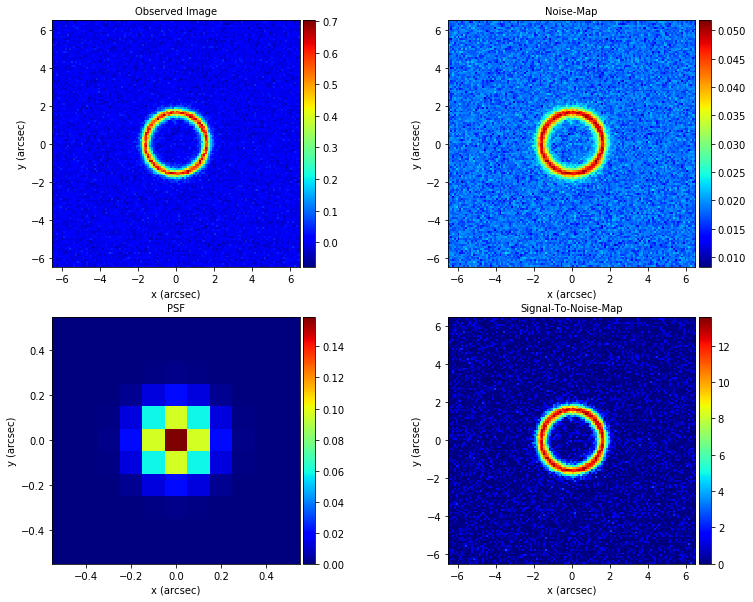

In [2]:
# Lets simulate the simple image we've used throughout this chapter again.
def simulate():

    from autolens.imaging import mask
    from autolens.model.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

    image_plane_grids = mask.ImagingGrids.grids_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6))
    source_galaxy = g.Galaxy(light=lp.SphericalExponential(centre=(0.0, 0.0), intensity=0.2, effective_radius=0.2))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=[image_plane_grids])

    image_simulated = im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                        exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return image_simulated

image = simulate()
imaging_plotters.plot_image_subplot(image=image)

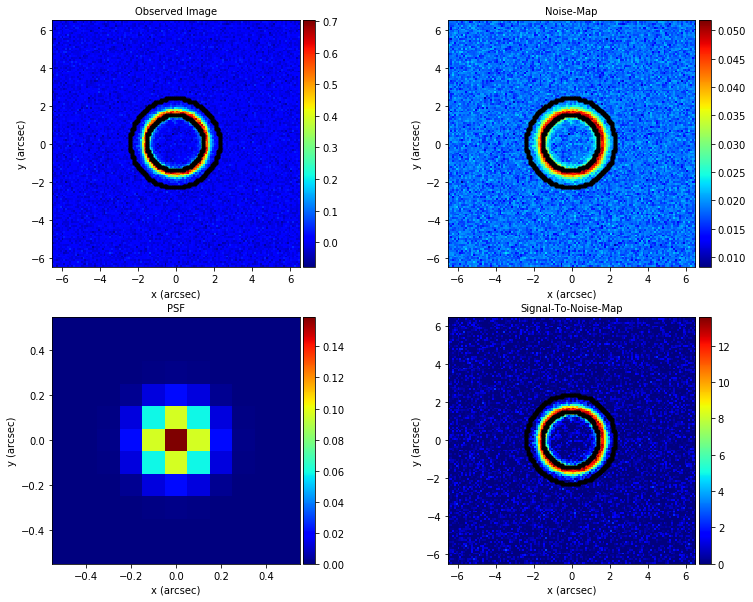

In [3]:
# When it comes to determining an appropriate mask for this image, the best approach is to set up a mask using the mask 
# module and pass it to an imaging plotter. You can then check visually if the mask is an appropriate size or not.
# Below, we choose an inner radius that cuts into our lensed source galaxy - clearly this isn't a good mask.
mask = msk.Mask.annular(shape=image.shape, pixel_scale=image.pixel_scale, inner_radius_arcsec=1.4,
                        outer_radius_arcsec=2.4)
imaging_plotters.plot_image_subplot(image=image, mask=mask)

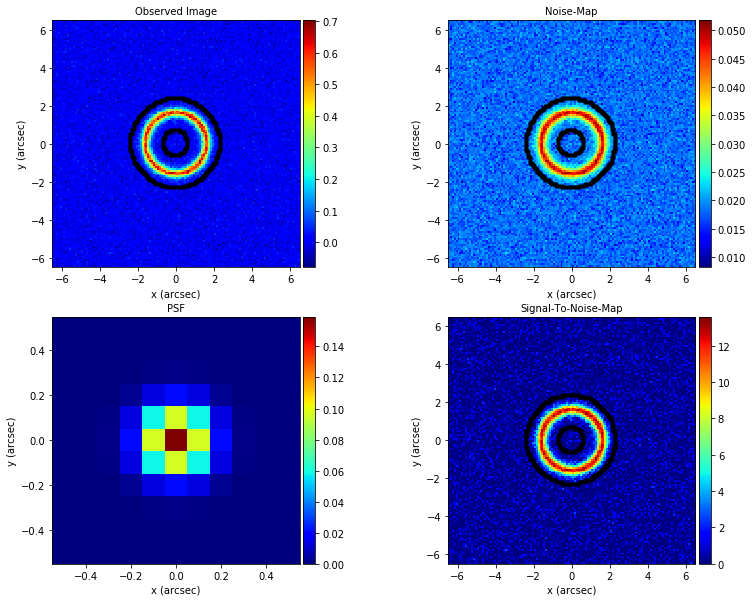

In [4]:
# So, lets decreasing the inner radius to correct for this
mask = msk.Mask.annular(shape=image.shape, pixel_scale=image.pixel_scale, inner_radius_arcsec=0.6,
                        outer_radius_arcsec=2.4)
imaging_plotters.plot_image_subplot(image=image, mask=mask)


In [5]:
# When we run the phase, we don't pass it the mask as an array. Instead, we pass it the mask as a function. The reason
# for this will become clear in the next chapter, but for now I would say you just accept this syntax.
def mask_function():
    return msk.Mask.annular(shape=image.shape, pixel_scale=image.pixel_scale, inner_radius_arcsec=0.6,
                        outer_radius_arcsec=2.4)

phase_with_custom_mask = ph.LensSourcePlanePhase(lens_galaxies=dict(lens_galaxy=g.Galaxy()),
                                source_galaxies=dict(source_galaxy=g.Galaxy()),
                                optimizer_class=non_linear.MultiNest,
                                mask_function=mask_function, # <---- here we pass the mask function
                                phase_name='1_non_linear_search')

In [6]:
# So, our mask encompasses the lensed source galaxy. However, is this really the right sized mask? Do we actually want
# a bigger mask? a smaller mask?

# When it comes to masking, we are essentially balancing run-speed and accuracy. If speed wasn't a consideration,
# bigger masks would *always* be better, for two reasons:

# 1) The lensed source galaxy may have very faint emission that when you look at the plot above you don't notice.
#    Overly aggressive masking risks you masking out some of that light - data which would better constrain your
#    lens model!

# 2) When you fit a an image with a model image, the fit is performed only within the masked region. Outside of the
#    masked region it is possible that the model image produces some source-galaxy light in a region of the image where
#    it isn't actually observed. If this region is masked, the poor fit in this region won't reduce the model's
#    likelihood.

# As you use PyAutoLens more, you will get a feel for how fast an analysis will run given a certain image resolution,
# lets model complexity, non-linear search priors / settings, etc. As you develop this intuition, I would recommend you
# always aim to use masks as big as possible, but still gives what you feel is a reasonable run-speed. Aggresive masking 
# will get your code running fast - but it could lead you to infer an incorrect lens model!

# If you are fitting the foreground lens galaxy's light, you pretty much have no choice but to use a large circular
# mask that will probably encompass the entire source-galaxy anyway.

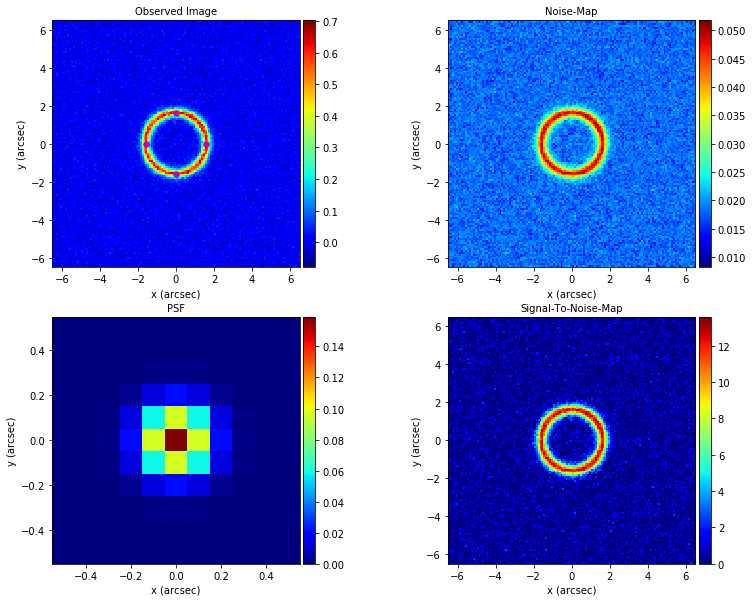

In [7]:
# We can also manually specify a set of image-pixels which correspond to the multiple images of the source-galaxy(s).
# During the analysis, PyAutoLens will first check that these pixels trace within a specified arc-second threshold of
# one another (which is controlled by the 'position_threshold' parameter of the 'general.ini' config file). This
# provides two benefits:

# 1) The analysis runs faster, as the non-linear search avoids searching regions of parameter space where the
#    mass-model is clearly not accurate.

# 2) By removing these solutions, a global-maximum solution may be reached instead of a local-maxima. This is because
#    removing the incorrect mass models makes the non-linear parameter space less complex.

# We can easily check the image-positions are accurate by plotting them using our imaging_plotter (they are the magenta
# dots on the image).
imaging_plotters.plot_image_subplot(image=image, positions=[[[1.6, 0.0], [0.0, 1.6], [-1.6, 0.0], [0.0, -1.6]]])

In [8]:
# We can then pass these positions to our phase such that every iteration of the non-linear search checks they trace
# close to one another.
phase_with_positions = ph.LensSourcePlanePhase(lens_galaxies=dict(lens_galaxy=g.Galaxy()),
                                                source_galaxies=dict(source_galaxy=g.Galaxy()),
                                                optimizer_class=non_linear.MultiNest,
                                                positions=[[[1.6, 0.0], [0.0, 1.6], [-1.6, 0.0], [0.0, -1.6]]],
                                                phase_name='1_positions')

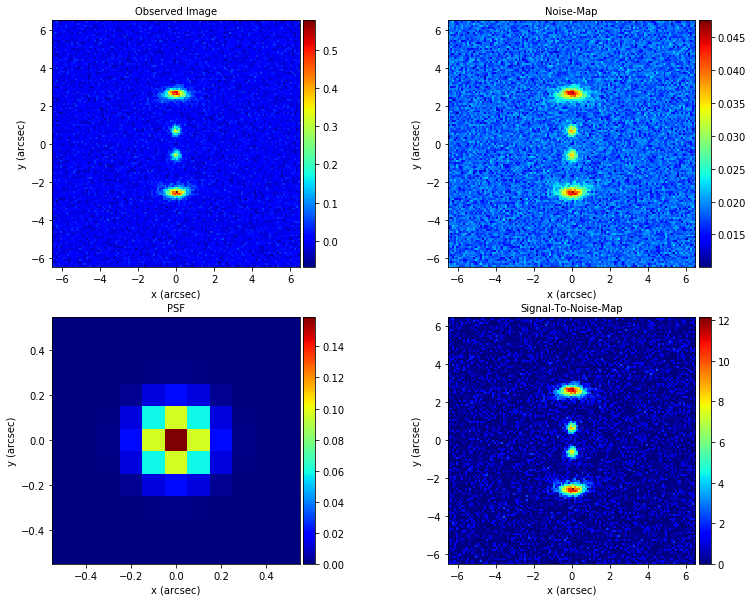

In [9]:
# You may observe multiple source-galaxies each with their own set of multiple-images. If you have a means by
# which to pair different positions to the same source galaxies (for example, spectroscopic data), you can set up
# multiple sets of positions, which each have to trace to within the position threshold of one another for the lens
# model to be accepted.

def simulate_two_source_galaxies():

    from autolens.imaging import mask
    from autolens.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

    image_plane_grids = mask.ImagingGrids.grids_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6))
    source_galaxy_0 = g.Galaxy(light=lp.SphericalExponential(centre=(1.0, 0.0), intensity=0.2, effective_radius=0.2))
    source_galaxy_1 = g.Galaxy(light=lp.SphericalExponential(centre=(-1.0, 0.0), intensity=0.2, effective_radius=0.2))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy_0,
                                                                                               source_galaxy_1],
                                                 image_plane_grids=[image_plane_grids])

    image_simulated = im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                                   exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return image_simulated

image = simulate_two_source_galaxies()
imaging_plotters.plot_image_subplot(image=image)

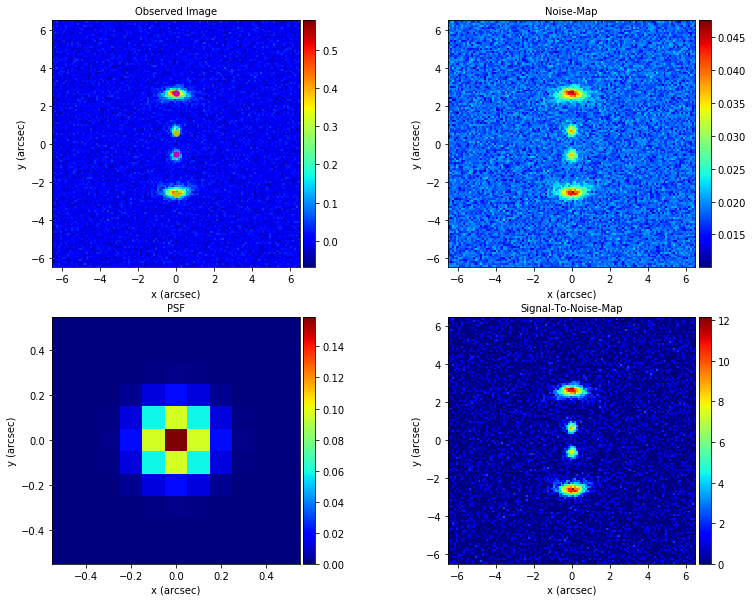

In [11]:
# To specify the positions, we break the positions list into two cells. They will be plotted in different colours to
# represent the fact they trace from different source galaxies.
imaging_plotters.plot_image_subplot(image=image, positions=[[[2.65, 0.0], [-0.55, 0.0]], [[-2.65, 0.0], [0.55, 0.0]]])

In [12]:
# Again, we can just pass this list of pixels to our phase.
phase_with_x2_positions = ph.LensSourcePlanePhase(lens_galaxies=dict(lens_galaxy=g.Galaxy()),
                                                  source_galaxies=dict(source_galaxy=g.Galaxy()),
                                                  optimizer_class=non_linear.MultiNest,
                                                  positions=[[[2.65, 0.0], [-0.55, 0.0]], [[-2.65, 0.0], [0.55, 0.0]]],
                                                  phase_name='1_x2_positions')

In [ ]:
# Tutorial complete! There are two things you should bare in mind in terms of masking and positions:
#
# 1) Customizing the mask and positions for the analysis of one strong lens gets the analysis running fast and can
#    provide accurate non-linear sampling. However, for a large sample of lenses, customizing the mask and positions
#    will begin to take a lot of time. If you're willing to put that time and effort in, great, but these solutions
#    *do not* scale-up to large samples of lenses.

# 2) A word of warning - be *extremely* careful when using positions, especially if it is unclear if the lensed source
#    galaxy has one or multiple source's of light. If your position threshold is small and the positions you give the
#    analysis correspond to different parts of the source, you may remove the *correct lens model*. In my experience,
#    as long as you keep the threshold above ~0.5" you'll be fine.

# And with that, we've completed the chapter.